In [10]:
import random
import os
import numpy as np
import pandas as pd
import numpy as np 
import pandas as pd 
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt 


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # 행운의 seed

In [5]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [6]:
train

,ID,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age,Calories_Burned
0,TRAIN_0000,26.0,105.6,107.0,5.0,9.0,154.3,Normal Weight,F,45,166.0
1,TRAIN_0001,7.0,103.3,88.0,6.0,6.0,224.9,Overweight,M,50,33.0
2,TRAIN_0002,7.0,103.3,86.0,6.0,3.0,218.3,Overweight,M,29,23.0
3,TRAIN_0003,17.0,104.0,99.0,5.0,6.0,147.7,Normal Weight,F,33,91.0
4,TRAIN_0004,9.0,102.7,88.0,5.0,10.0,169.8,Normal Weight,M,38,32.0
...,...,...,...,...,...,...,...,...,...,...,...
7495,TRAIN_7495,22.0,105.1,104.0,4.0,10.0,112.4,Normal Weight,F,75,151.0
7496,TRAIN_7496,20.0,105.3,104.0,5.0,8.0,147.7,Normal Weight,F,21,114.0
7497,TRAIN_7497,8.0,103.1,90.0,6.0,2.0,202.8,Overweight,M,57,41.0
7498,TRAIN_7498,12.0,104.4,97.0,5.0,9.0,167.6,Overweight,M,35,57.0


In [7]:
train["Height"] = train.pop("Height(Feet)") * 30.48 + train.pop("Height(Remainder_Inches)") * 2.54
test["Height"] = test.pop("Height(Feet)") * 30.48 + test.pop("Height(Remainder_Inches)") * 2.54

train["Weight"] = train.pop("Weight(lb)") * 0.453592
test["Weight"] = test.pop("Weight(lb)") * 0.453592

train["Body_Temperature"] = (train.pop("Body_Temperature(F)") - 32) / 1.8
test["Body_Temperature"] = (test.pop("Body_Temperature(F)") - 32) / 1.8
train["BMI"] = train["Weight"] / (train["Height"] / 100)**2
test["BMI"] = test["Weight"] / (test["Height"] / 100)**2

train = train.drop("Weight_Status", axis=1)
test = test.drop("Weight_Status", axis=1)

train["Gender"] = train["Gender"].map({"F": 0, "M": 1})
test["Gender"] = test["Gender"].map({"F": 0, "M": 1})
train["Calories_Burned"] = np.log1p(train["Calories_Burned"])

train["Age"] = np.log(train["Age"])
test["Age"] = np.log(test["Age"])

body_temp_mean = train["Body_Temperature"].mean()
body_temp_std = train["Body_Temperature"].std()
train["Body_Temperature"] = (((train["Body_Temperature"] - body_temp_mean) / body_temp_std) + 4)**3
test["Body_Temperature"] = (((test["Body_Temperature"] - body_temp_mean) / body_temp_std) + 4)**3

In [8]:
# 독립변수로 설정할 train_x에서는 종속변수를 제거합니다. 또한 분석에 활용하지 않는 ID 데이터를 제거합니다.
X = train.drop(['ID','Calories_Burned'], axis = 1)
# train_y 변수를 종속변수로 사용하기 위해 Calories_Burned 데이터를 지정하였습니다.
Y = train['Calories_Burned']

# train_x 데이터와 마찬가지로 분석에 활용하지 않는 ID 데이터를 제거합니다.
test_x = test.drop('ID', axis = 1)


스케일링

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Scale_train = scaler.fit_transform(X)
Scale_test  = scaler.fit_transform(test_x)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(Scale_train, Y,shuffle=True, test_size=0.3)

In [13]:
tf.keras.activations.gelu
tf.keras.activations.selu
tf.keras.activations.elu


model = tf.keras.Sequential([
  tf.keras.layers.Dense(256, activation="selu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation="selu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation="elu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(32, activation="selu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(16, activation="elu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1,activation='linear')    
])

In [14]:
early_stopping = callbacks.EarlyStopping(monitor="val_loss",patience=15,restore_best_weights=True)

In [15]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1 ,patience=5,min_lr=0.0001)

In [18]:
y_test

970     2.995732
6279    4.890349
1859    4.795791
6803    2.639057
6305    3.044522
          ...   
1773    3.091042
3761    4.248495
1209    4.276666
3936    5.484797
4317    4.718499
Name: Calories_Burned, Length: 2250, dtype: float64

In [19]:
# To Comiple the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))          

In [20]:
predictions = model.fit(X_train,y_train,epochs=100,callbacks=[early_stopping,reduce_lr],validation_data=(X_test, y_test))

Epoch 1/100
165/165 [==============================] - 10s 12ms/step - loss: 3.0095 - val_loss: 0.0566 - lr: 0.0050
Epoch 2/100
165/165 [==============================] - 1s 5ms/step - loss: 1.0108 - val_loss: 0.1404 - lr: 0.0050
Epoch 3/100
165/165 [==============================] - 1s 5ms/step - loss: 0.7626 - val_loss: 0.0370 - lr: 0.0050
Epoch 4/100
165/165 [==============================] - 1s 5ms/step - loss: 0.6154 - val_loss: 0.0657 - lr: 0.0050
Epoch 5/100
165/165 [==============================] - 1s 5ms/step - loss: 0.4893 - val_loss: 0.0234 - lr: 0.0050
Epoch 6/100
165/165 [==============================] - 1s 5ms/step - loss: 0.3867 - val_loss: 0.0243 - lr: 0.0050
Epoch 7/100
165/165 [==============================] - 1s 5ms/step - loss: 0.3203 - val_loss: 0.0328 - lr: 0.0050
Epoch 8/100
165/165 [==============================] - 1s 5ms/step - loss: 0.2667 - val_loss: 0.0293 - lr: 0.0050
Epoch 9/100
165/165 [==============================] - 1s 5ms/step - loss: 0.2374 - va

<Axes: >

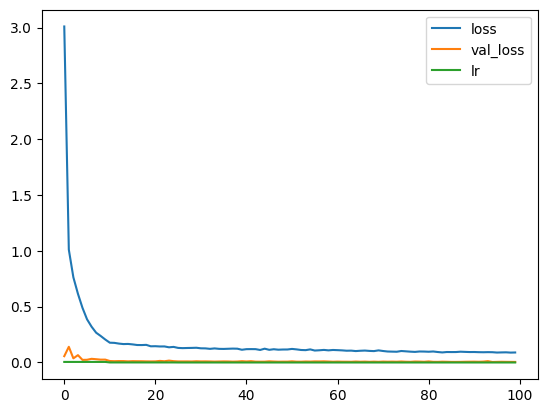

In [21]:
pd.DataFrame(predictions.history).plot()

In [22]:
pred = model.predict(Scale_test)

235/235 [==============================] - 1s 2ms/step


In [23]:
pred

array([[5.1429143],
       [5.1983843],
       [3.9180133],
       ...,
       [4.8749704],
       [3.4910157],
       [5.2162266]], dtype=float32)

In [24]:
original_predictions = np.expm1(pred)

In [25]:
original_predictions

array([[170.214   ],
       [179.9796  ],
       [ 49.300415],
       ...,
       [129.97028 ],
       [ 31.819265],
       [183.23767 ]], dtype=float32)

In [27]:
submission = pd.read_csv('/content/sample_submission.csv')

In [28]:
submission['Calories_Burned'] = original_predictions

In [29]:
submission.to_csv('/content/kaggle_reference.csv', index = False)